In [1]:
import os
import cv2
#import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
from keras import layers
#from moviepy.editor import *
%matplotlib inline
from keras.models import Model
from sklearn.model_selection import train_test_split
 
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam

In [2]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

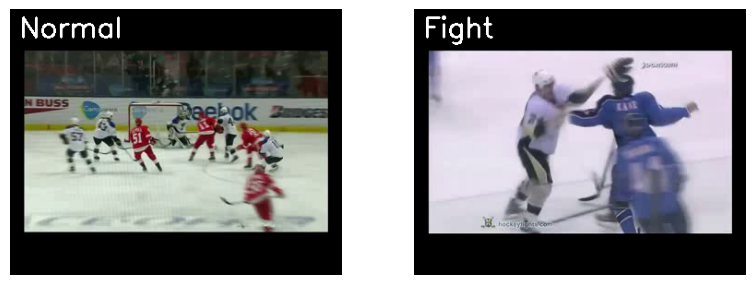

In [3]:
plt.figure(figsize = (20, 20))
 
# Get the names of all classes/categories in UCF50.
all_classes_names = os.listdir('E:/saad/Hockey_violence_detection/dataset')
 
# Generate a list of 20 random values. The values will be between 0-50, 
# where 50 is the total number of class in the dataset. 
random_range = random.sample(range(len(all_classes_names)), 2)
 
# Iterating through all the generated random values.
for counter, random_index in enumerate(random_range, 1):
 
    # Retrieve a Class Name using the Random Index.
    selected_class_Name = all_classes_names[random_index]
 
    # Retrieve the list of all the video files present in the randomly selected Class Directory.
    video_files_names_list = os.listdir(f'E:/saad/Hockey_violence_detection/dataset/{selected_class_Name}')
 
    # Randomly select a video file from the list retrieved from the randomly selected Class Directory.
    selected_video_file_name = random.choice(video_files_names_list)
 
    # Initialize a VideoCapture object to read from the video File.
    video_reader = cv2.VideoCapture(f'E:/saad/Hockey_violence_detection/dataset/{selected_class_Name}/{selected_video_file_name}')
    
    # Read the first frame of the video file.
    _, bgr_frame = video_reader.read()
 
    # Release the VideoCapture object. 
    video_reader.release()
 
    # Convert the frame from BGR into RGB format. 
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
 
    # Write the class name on the video frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    
    # Display the frame.
    plt.subplot(5, 4, counter);plt.imshow(rgb_frame);plt.axis('off')

In [4]:
IMAGE_HEIGHT , IMAGE_WIDTH = 100, 100
 
# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 20
 
# Specify the directory containing the UCF50 dataset. 
DATASET_DIR = "E:/saad/Hockey_violence_detection/dataset"
 
# Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.
CLASSES_LIST = ["Fight","Normal"]

In [5]:

def frames_extraction(video_path):
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''
 
    # Declare a list to store video frames.
    frames_list = []
    
    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)
 
    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
 
    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 2)
 
    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):
 
        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
 
        # Reading the frame from the video. 
        success, frame = video_reader.read() 
 
        # Check if Video frame is not successfully read then break the loop
        if not success:
            break
 
        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        #normalized_frame = resized_frame / 255
        
        # Append the normalized frame into the frames list
        frames_list.append(resized_frame)
    
    # Release the VideoCapture object. 
    video_reader.release()
 
    # Return the frames list.
    return frames_list

In [6]:
def create_dataset():
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''
 
    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []
    
    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):
        
        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')
        
        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        
        # Iterate through all the files present in the files list.
        for file_name in files_list:
            
            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
 
            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)
 
            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:
 
                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)
 
    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)  
    
    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths

In [7]:
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: Fight
Extracting Data of Class: Normal


In [8]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size = 0.1, shuffle = True, random_state = seed_constant)

In [9]:
#Normalization
x_train=x_train/255.
x_test=x_test/255.

In [10]:
# Once hot encoding
y_train=to_categorical(y_train)

In [11]:
x_train=x_train.reshape(900,100,100,20,3)
x_test=x_test.reshape(100,100,100,20,3) 

In [12]:
print('Feature shape is \t',x_train.shape)

Feature shape is 	 (900, 100, 100, 20, 3)


In [13]:
width,height,depth,channel=100,100,20,3

In [14]:
from attention_module import attach_attention_module
import keras

In [15]:
def proposed_framework():
    
    inputs=tf.keras.Input(shape=(width,height,depth,channel))
    
    x=Conv3D(32,(3,3,3),activation='relu',padding='same')(inputs)
    #x=MaxPooling3D(pool_size=(2, 2,2))(x)
    x=BatchNormalization()(x)
    
    x=Conv3D(32,(3,3,3),activation='relu',padding='same')(x)
    x=MaxPooling3D(pool_size=(2, 2,2))(x)
    x=BatchNormalization()(x)
    
    x=Conv3D(64,(3,3,3),activation='relu',padding='same')(x)
    #x=MaxPooling3D(pool_size=(2, 2,2))(x)
    x=BatchNormalization()(x)
    
    x=Conv3D(64,(3,3,3),activation='relu',padding='same')(x)
    x=MaxPooling3D(pool_size=(2, 2,2))(x)
    y=BatchNormalization()(x)
    
    x=Conv3D(128,(3,3,3),activation='relu',padding='same')(x)
    x=MaxPooling3D(pool_size=(2, 2,2))(x)
    x=BatchNormalization()(x)
    
    x=Conv3D(128,(3,3,3),activation='relu',padding='same')(x)
    x=MaxPooling3D(pool_size=(2, 2,2))(x)
    y=BatchNormalization()(x)
    
    x = attach_attention_module(y, 'se_block')
    x = keras.layers.add([x, y])
    x = Activation('relu')(x)
    x = GlobalAveragePooling3D()(x)
    #x = Flatten()(x)
    x = Dense(2,activation='softmax',kernel_initializer='he_normal')(x)
    
    model=Model(inputs=inputs,outputs=x)
    return model

In [16]:
model = proposed_framework()

In [17]:
# model summarymodel
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 2  0           []                               
                                0, 3)]                                                            
                                                                                                  
 conv3d (Conv3D)                (None, 100, 100, 20  2624        ['input_1[0][0]']                
                                , 32)                                                             
                                                                                                  
 batch_normalization (BatchNorm  (None, 100, 100, 20  128        ['conv3d[0][0]']                 
 alization)                     , 32)                                                         

In [18]:
opt = Adam(learning_rate=0.0003)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
history = model.fit(
    x_train,y_train,
    batch_size=4,
    epochs=50,
    validation_split = 0.2,
#     callbacks=callbacks
)

Epoch 1/50
180/180 [==============================] - 36s 164ms/step - loss: 0.4523 - accuracy: 0.8083 - val_loss: 0.9111 - val_accuracy: 0.4944
Epoch 2/50
180/180 [==============================] - 29s 160ms/step - loss: 0.3620 - accuracy: 0.8514 - val_loss: 0.6492 - val_accuracy: 0.5833
Epoch 3/50
180/180 [==============================] - 28s 158ms/step - loss: 0.3017 - accuracy: 0.8875 - val_loss: 0.4624 - val_accuracy: 0.8500
Epoch 4/50
180/180 [==============================] - 29s 159ms/step - loss: 0.3186 - accuracy: 0.8806 - val_loss: 0.3285 - val_accuracy: 0.9111
Epoch 5/50
180/180 [==============================] - 29s 159ms/step - loss: 0.2648 - accuracy: 0.9028 - val_loss: 0.6125 - val_accuracy: 0.7889
Epoch 6/50
180/180 [==============================] - 29s 162ms/step - loss: 0.2231 - accuracy: 0.9250 - val_loss: 0.1798 - val_accuracy: 0.9444
Epoch 7/50
180/180 [==============================] - 29s 159ms/step - loss: 0.2109 - accuracy: 0.9292 - val_loss: 0.3573 - val_ac

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


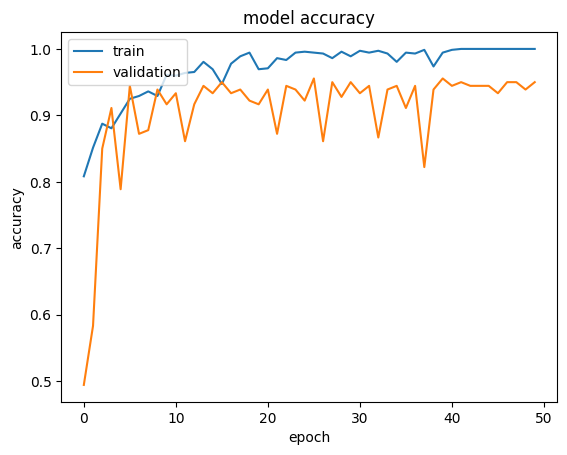

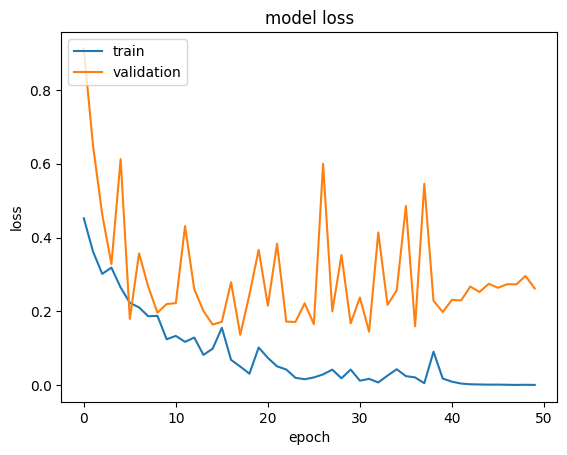

In [20]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

C:\ProgramData\Anaconda3\envs\dl\lib\site-packages\ipykernel_launcher.py:6: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


Normalized confusion matrix


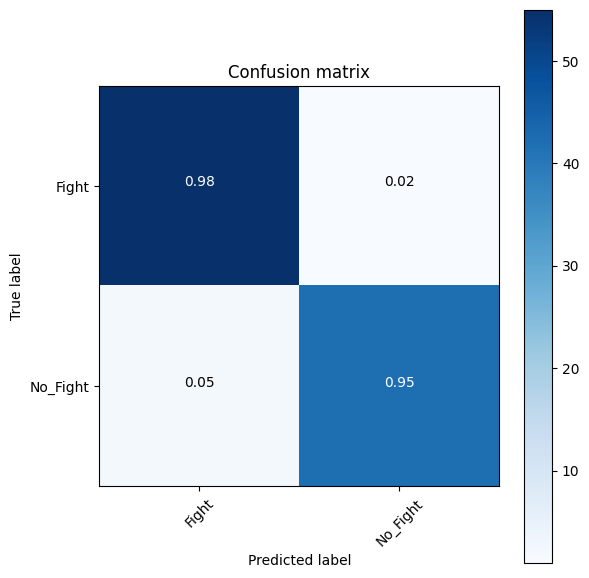

In [21]:
np.set_printoptions(precision=2)
class_names = ["Fight","No_Fight"]
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix 
from sklearn.metrics import ConfusionMatrixDisplay
Y_pred = model.predict_generator(x_test)
y_pred = np.argmax(Y_pred, axis=1)

cm = confusion_matrix(y_test, y_pred)
#plot_confusion_matrix(X = y_pred, y_true=y_test, labels = class_names, normalize=False)

import matplotlib.pyplot as plt
import itertools 
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):

    """

    This function prints and plots the confusion matrix.

    Normalization can be applied by setting `normalize=True`.

    """

    plt.figure(figsize=(6,6))



    plt.imshow(cm, interpolation='nearest', cmap=cmap)

    plt.title(title)

    plt.colorbar()



    tick_marks = np.arange(len(classes))

    plt.xticks(tick_marks, classes, rotation=45)

    plt.yticks(tick_marks, classes)



    if normalize:

        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        cm = np.around(cm, decimals=2)

        cm[np.isnan(cm)] = 0.0

        print("Normalized confusion matrix")

    else:

        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):

        plt.text(j, i, cm[i, j],

                 horizontalalignment="center",

                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()

    plt.ylabel('True label')

    plt.xlabel('Predicted label')

plot_confusion_matrix(cm, class_names)

In [22]:
#----------------Other Metrics ---------------------
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97        56
           1       0.98      0.95      0.97        44

    accuracy                           0.97       100
   macro avg       0.97      0.97      0.97       100
weighted avg       0.97      0.97      0.97       100

